<img src="https://margaritaimpresora.files.wordpress.com/2013/11/di-logo-sanjoaquin.jpg" title="USM" width="70%" height="70%" style="float: left;"/>

<br><br><br><br><br><br><br><br><br><br>
_____

<center>
   <h2>Tarea 1: Implementar un Neural IR.</h2>
   <h2>Recuperación de información </h2>
   <h4>Profesor: Marcelo Mendoza</h4>
   <h4>Estudiante: Fernanda Weiss</h4>
</center>

### Datos:
* topics.51-100: Campo "title" serán las consultas.
* wsj2.xml: Colección de evaluación, contiene los documentos, el corpus, sobre los que se harán las queries.
* script.py: Parsea el corpus, wsj2.xml
* qrels.51-100: Ground truth de los docs relevantes (1) y los no (0)

Se ejecuta *script.py*, *script2.py* y *qrels.py*, produciendo:
* corpus/: Carpeta que contiene la colección completa separada por archivos. Carpeta que tiene 10.163 documentos.
* queries: Archivo de texto que contiene en cada línea los títulos de tópicos que son las consultas.
* qrels: Archivo que filtra el archivo original *qrels.51-100*, obteniendo solos los documentos del corpus en estudio.


## Pasos a seguir:
0. Leer documentos
1. Pre-procesar el texto
2. Crear vocabulario y reconstruir documentos
3. Crear índice invertido
4. W2V skip-grams
5. Vectorizar documentos
6. Recuperar documentos usando el índice invertido
7. Implementar AWE y recuperar documentos con AWE para obtener Top-m de los recuperados antes (ej top-50)
8. Rankear con BM25 para obtener top-n (ej top-10)
9. Obtener métricas: precision and recall

In [1]:
import numpy as np

import matplotlib.pyplot as plt

import os

import operator  

from collections import defaultdict, Counter

import pandas as pd

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk import FreqDist

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_recall_fscore_support, classification_report

from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import skipgrams
from keras.layers import Merge
from keras.layers.core import Dense, Reshape
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.utils.vis_utils import model_to_dot

from IPython.display import SVG

import gensim

/home/fefi/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### 1) Leer documentos

In [2]:
docs_dir = os.listdir("corpus/")
docs = {}
for file in docs_dir:
    docs[file.title()] = "".join(open("corpus/"+file).readlines())
print("Hay {} documentos en el corpus".format(len(list(docs.values()))))

Hay 10163 documentos en el corpus


### 2) Pre-procesar el texto

Primero se aplica:
* tokenización con la función *word_tokenize* de NLTK
* eliminan los números y símbolos

In [3]:
def gen_dist(texts):
    word_dist = FreqDist()
    for s in texts:
        word_dist.update(s)
    return word_dist

def plt_zipf(dist):
    plt.figure(figsize=(12,6))
    dist.plot(50)

In [4]:
#Diccionario {id_doc: texto tokenizado}
corpus_nltk = docs.copy()
for id_doc, text in corpus_nltk.items():
    corpus_nltk[id_doc] = [token.lower() for token in word_tokenize(text) if token.isalpha() ] 

Solo con las acciones mencionadas se ve como el vocabulario es muy grande, y al comienzo de la distribución de palabras hay muchas stopword. 

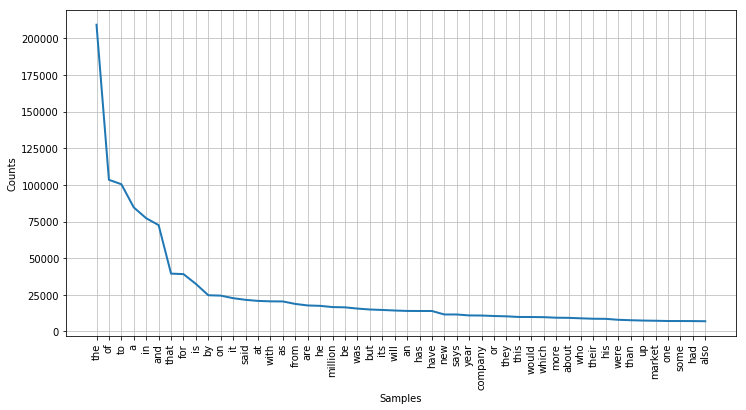

In [5]:
dist_nltk = gen_dist(corpus_nltk.values())
plt_zipf(dist_nltk)

Ahora se aplica:
* eliminar stopwords
* eliminar palabras de largo 1
* Stem -> tentador pero no se hizo
* eliminar palabras con freq 1 -> tampoco se hizo

In [6]:
other_stopwords = ['...','.','!',' ',';',',','``',"''",'--']
stoplist = np.concatenate((stopwords.words('english'),other_stopwords),axis=0)

#stemmer = SnowballStemmer("english")

In [7]:
for id_doc in corpus_nltk:
    corpus_nltk[id_doc] = [token for token in corpus_nltk[id_doc] if token not in stoplist]
    corpus_nltk[id_doc] = [token for token in corpus_nltk[id_doc] if len(token)>2]
   # corpus_nltk[id_doc] = [stemmer.stem(token) for token in corpus_nltk[id_doc]]

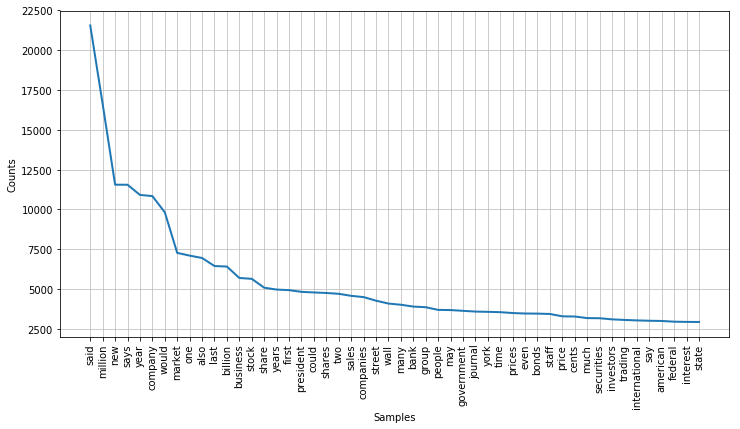

In [8]:
dist_nltk = gen_dist(corpus_nltk.values())
plt_zipf(dist_nltk)

### 3) Crear vocabulario y recostruir documentos 

In [9]:
voc = set()
for doc in corpus_nltk:
    for word in corpus_nltk[doc]:
        voc.add(word)

word2id = {w: i for i, w in enumerate(voc)}
id2word = {i: w for i, w in enumerate(voc)}

In [10]:
print("El vocabulario es de largo: ", len(voc))

El vocabulario es de largo:  58968


In [11]:
#recontruir los documentos con los ids de las palabras. Es necesario para skip-grams
corpus_ids = [[word2id[word] for word in doc] for doc in corpus_nltk.values()]

In [12]:
'topic' in voc

True

### 4) Crear índice invertido

Se crea un índice invertido en que aparte de indicar que documentos contiene una palabra, indica la frecuencia de la palabra en el documento.

In [13]:
inv_indx = defaultdict(list)
for i, (idx, text) in enumerate(corpus_nltk.items()):
    c = Counter(text)
    for word in text:
        if word in voc:
            if word in inv_indx:
                inv_indx[word].update({idx: c[word]})
            else:
                inv_indx[word] = dict([(idx, c[word])])

In [14]:
inv_indx['news']['Wsj920319-0167']

1

### 5) Skip-grams

Se aplica word2vec con el modelo de skip-grams para generar el espacio de embedding.

In [34]:
# generate skip-grams
skip_grams = [skipgrams(corpus_id, len(voc), window_size=2) for corpus_id in corpus_ids]

In [35]:
# view sample skip-grams
pairs, labels = skip_grams[3][0], skip_grams[3][1]
for i in range(10):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          id2word[pairs[i][0]], pairs[i][0], 
          id2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(shares (19238), buying (23153)) -> 1
(market (39261), propelling (37124)) -> 1
(cautious (16656), turned (13967)) -> 1
(volume (20401), hattery (2883)) -> 0
(would (37689), make (35276)) -> 1
(dominates (58850), tops (5931)) -> 1
(also (22281), organic (38923)) -> 0
(growth (5264), slowing (17595)) -> 1
(kong (13536), australia (45542)) -> 1
(tokyo (57712), curable (35960)) -> 0


In [37]:
skip_grams = [i for i in skip_grams if i[0]] #eliminar documentos de largo 1, no tiene pares

In [17]:
vocab_size = len(word2id) + 1 
embed_size = 100  #capa oculta. Tamaño de la representación de las palabras

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  # This is added back by InteractiveShellApp.init_path()


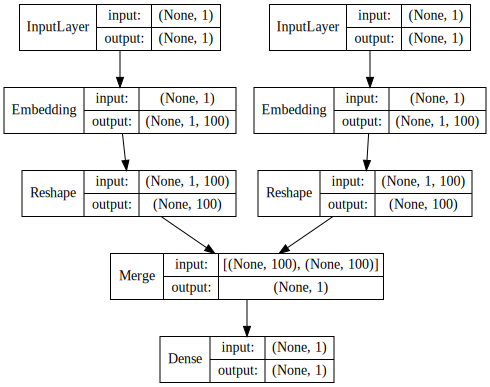

In [18]:
# build skip-gram architecture
word_model = Sequential()
word_model.add(Embedding(vocab_size, embed_size, embeddings_initializer="glorot_uniform",input_length=1))
word_model.add(Reshape((embed_size, )))

context_model = Sequential()
context_model.add(Embedding(vocab_size, embed_size, embeddings_initializer="glorot_uniform", input_length=1))
context_model.add(Reshape((embed_size,)))

model = Sequential()
model.add(Merge([word_model, context_model], mode="dot"))
model.add(Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid"))
model.compile(loss="mean_squared_error", optimizer="rmsprop", metrics=['accuracy'])

# visualize model structure
SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

In [19]:
model.load_weights('skipgram_model_weights.h5')

In [20]:
merge_layer = model.layers[0]
word_model = merge_layer.layers[0]
word_embed_layer = word_model.layers[0]
weights = word_embed_layer.get_weights()[0][1:]


In [21]:
print(weights.shape)
pd.DataFrame(weights, index=id2word.values()).head()

(58968, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
predictable,0.007868,0.010144,0.009025,-0.010367,0.010575,-0.012090,0.005458,-0.012132,-0.010892,-0.007147,...,0.009107,0.007675,-0.002904,-0.004651,-0.005328,-0.016413,-0.018550,0.013637,-0.012488,0.009353
discounts,0.020990,0.031498,0.013622,-0.014429,0.020345,-0.013031,0.025124,-0.026289,-0.016788,-0.014964,...,0.012686,0.031038,-0.015247,-0.012297,-0.024251,-0.022514,-0.013594,0.023636,-0.013410,0.031229
hapoalim,0.013245,0.015388,0.022099,-0.017214,0.017679,-0.025858,0.021715,-0.012116,-0.017118,-0.028569,...,0.020008,0.019774,-0.023013,-0.018877,-0.014679,-0.023977,-0.018028,0.013380,-0.015443,0.023370
shosh,-0.000475,0.009485,0.003470,-0.011353,0.006156,-0.003682,0.013465,-0.017629,-0.005070,-0.009578,...,0.006450,0.012243,-0.017679,-0.004319,-0.018065,-0.009860,0.000603,0.017128,-0.006148,0.009509
eiti,0.028781,0.032943,0.035181,-0.029452,0.032276,-0.029870,0.036822,-0.045764,-0.048259,-0.029427,...,0.019292,0.037652,-0.029740,-0.034739,-0.036427,-0.033106,-0.050496,0.044226,-0.035138,0.023962


### 6) Vectorizar documentos (AWE)


Se vectoriza el corpus offline para la recuperación con las futuras queries, y así sólo se vectoriza la query.

La vectorización de los documento se realiza bajo la agregación de los words embedding por promedio de cada documento/query con Average Wor Embedding (AWE):

$$\vec{v_d} = \frac{1}{|d|} \sum_{t \in d} \frac{\vec{v_t}}{||\vec{v_t}||}$$

In [22]:
def vectorize_doc(doc_emb):
    doc_size = len(doc_emb)
    doc = []
    for word in doc_emb:
        norm = np.linalg.norm(word)
        doc.append(np.divide(word, norm))
    return np.divide(np.sum(doc, axis=0), len(doc_emb))

def vectorize_corpus(corpus):
    corpus_emb = [[weights[word2id[word]] for word in doc] for doc in corpus.values()]
    
#     corpus_awe = [vectorize_doc(doc) for doc in corpus_emb]
    corpus_awe = {}    
    for i, id_doc in enumerate(corpus):
        corpus_awe[id_doc] = vectorize_doc(corpus_emb[i])
        
    return corpus_awe

In [23]:
corpus_awe = vectorize_corpus(corpus_nltk)

In [25]:
corpus_awe

{'Wsj920312-0019': array([ 0.08890869,  0.09369496,  0.0896074 , -0.09726256,  0.08766197,
        -0.08531943,  0.10435352, -0.09371679, -0.09379239, -0.09217942,
         0.08788121,  0.08638915,  0.09147714, -0.08609122, -0.09135039,
        -0.09934561,  0.08581198,  0.0873033 ,  0.08726833,  0.09823696,
         0.08836089, -0.0830008 , -0.09565181, -0.08149667,  0.09029143,
         0.10041889,  0.09083625,  0.09334265, -0.10121398, -0.09156799,
        -0.0883151 ,  0.08613484, -0.09583744, -0.08808338, -0.08768872,
         0.09238072, -0.08429248,  0.08734658, -0.08802556,  0.09869123,
        -0.09701269,  0.08079749,  0.08318903,  0.08273963,  0.08408773,
         0.079056  , -0.09278694, -0.09640435,  0.0931839 , -0.08951961,
        -0.10039752, -0.09740088,  0.09123237, -0.0981173 , -0.10022151,
        -0.09058654, -0.09669707, -0.09405775, -0.09806946,  0.0988612 ,
         0.08528116,  0.08812841, -0.10124478,  0.08833314, -0.10029343,
        -0.09548678, -0.10182571,

### 7) Recuperar documentos usando el índice invertido

Se leen todas las consultas las consultas, las cuales se tokenizan y dejan solo con las palabras que están en el vocabulario

In [24]:
#Leer query
queries = open("queries").readlines() #+51 al indice para saber el topico
queries = [[token.lower() for token in word_tokenize(query) if token.isalpha() ]for query in queries ]
queries = [voc.intersection(set(query)) for query in queries]

Luego, se recuperan todos los documentos que tiene al menos una palara de la query. Esto es utilizando un modelo Bag-Of-Words (BOW) y se aplica a la query con un modelo booleano con el operador OR.

In [25]:
def docs_retrieval(voc, query, indx_inv):
    #Recupera los documentos que contienen al menos una palabra de la query
    doc_ret = set()
    for word in voc.intersection(set(query)):
        for doc in indx_inv[word]:
            doc_ret.add(doc)

    return list(doc_ret)

In [26]:
doc_ret_all_queries = [ docs_retrieval(voc, query, inv_indx) for query in queries]

In [27]:
len(doc_ret_all_queries)

50

### 8) Recuperar documentos con AWE para obtener Top-m de los recuperados antes (ej top-50)


Primero se llevan todas las queries al espacio de embedding generado y se vectorizan mediante AWE. Luego se aplica la similitud de coseno entre una query con todos los documentos recuerados con el paso anterior, BOW OR. De esta forma de obtiene los Top-M documentos que sean más similares a la query de acuerdo a la métrica de coseno utilizada.

In [28]:
def awe_query(query, word_embeddings):
#     print(query)
    query_emb = [weights[word2id[word]] for word in query]
    return vectorize_doc(query_emb)

def obtain_topm_aw(documents_retrieval, query, corpus, m):
    sim = {}
    for doc in documents_retrieval:
        sim[doc] = cosine_similarity(np.array(query).reshape(1, -1), np.array(corpus[doc]).reshape(1, -1))
        
    sim = sorted(sim.items(), key = operator.itemgetter(1) ,reverse = True)
    if m > len(sim):
        return sim
    return sim[:m]

In [29]:
#recuperar top-50 mejores documentos desde los recuperados antes
query_awe_all = [awe_query(query, weights) for query in queries]
m = 50
top_awe_all_queries = [obtain_topm_aw(doc_ret_all_queries[i], query_awe_all[i], corpus_awe, m) for i in range(len(query_awe_all))]

In [30]:
print(len(query_awe_all))
print(len(top_awe_all_queries))

50
50


### 9) Rankear con BM25 para obtener top-n (ej top-10)

Se aplica la función de ranking Okapi BM25:

$$ Okapi(D,Q) = \sum_i log \left( \frac{r + 0.5/ R - r + 0.5}{n - r + 0.5 / N - n - R + r +0.5} \right) * \frac{f_i(k1+1)}{f_i + k1(1-b+b\frac{|D|}{avgdl})} * \frac{qf(k2+1)}{qf + k2} $$

Función que no es la expresada originalmente, pero es mejor para los casos en que las queries son largas o hay documentos muy largos [1](https://nlp.stanford.edu/IR-book/html/htmledition/okapi-bm25-a-non-binary-model-1.html). Un ejemplo de cómo aplicar la función se encuentra [aquí](https://www.quora.com/How-does-BM25-work)

In [31]:
def score_BM25(n, f, qf, r, N, dl, avdl):
    K = compute_K(dl, avdl)
    first = np.log( ( (r + 0.5) / (R - r + 0.5) ) / ( (n - r + 0.5) / (N - n - R + r + 0.5)) )
    second = ((k1 + 1) * f) / (K + f)
    third = ((k2+1) * qf) / (k2 + qf)
    return first * second * third

def compute_K(dl, avdl):
    return k1 * ((1-b) + b * (float(dl)/float(avdl)) )

In [87]:
def score_query(query, top_awe, N, corpus, inv_indx, top_n):
    query_result = dict()
    avdl = np.average([len(corpus[i[0]]) for i in top_awe])
    n = len(top_awe)
    for i in top_awe:
        id_doc = i[0]
        doc = corpus[id_doc]
        freq = inv_indx[doc[0]][id_doc]
        score = score_BM25(n = n, f=freq, qf=1, r=0, N=N, dl=len(doc), avdl=avdl) # calculate score
        if id_doc in query_result: #this document has already been scored once
            query_result[id_doc] += score
        else:
            query_result[id_doc] = score
            
    query_result = sorted(query_result.items(), key = operator.itemgetter(1) ,reverse = True)
    if n > len(query_result):
        return query_result
    return query_result[:top_n]

In [88]:
k1 = 1.2
k2 = 100
b = 0.75
R = 0.0
top = 10

query_result_all = []
for i in range(len(queries)):
    query_result_all.append(score_query(query = queries[i], top_awe = top_awe_all_queries[i], 
                                        N = len(corpus_awe), corpus = corpus_nltk, 
                                        inv_indx = inv_indx, top_n = top))

In [89]:
len(query_result_all)

50

### 10) Obtener métricas: precision and recall

Finalmente ya que se han recuperado slo Top-N documentos más relevantes a cada query, se procede a evaluar la recuperación, tomando como ground truth lo entregado por el archivo *qrels*, en donde hay documentos marcado como relevantes (1) y no relevantes (0). 

Hay que tener en cuenta que para ciertas queries solo hay docuementos no relevantes, y en el resto hay muy pocos documentos relevantes. 

In [90]:
def create_gt(filename):
    qrels = open(filename).read().splitlines()
    ground_truth = {}
    for qrel in qrels:
        id_query, id_doc, rel = qrel.split()
        if id_query in ground_truth:
            ground_truth[id_query].update({id_doc: rel})
        else:
            ground_truth[id_query] = dict([(id_doc, rel)])
    
    return ground_truth

# def query_gt(id_query, ground_truth):
#     return list(ground_truth[id_query].keys()), list(ground_truth[id_query].values())

def obtain_ypred_y_true(id_query, ground_truth, doc_retrieval):
    docs_true = list(ground_truth[id_query].keys())
#     print(docs_true)
#     print(doc_retrieval)
    y_true = list(ground_truth[id_query].values())
    
    y_pred = []
    for doc in docs_true:
#         print(doc.upper())
        if doc.upper() in doc_retrieval and ground_truth[id_query][doc] == '1': #que efectivamente sea relevante
            y_pred.append('1')
        else:
            y_pred.append('0')
    return y_pred, y_true

In [91]:
ground_truth = create_gt('qrels')

In [92]:
labels = {}
for i in range(len(query_result_all)):
    docs_retrieval_final = [doc.upper() for doc in list(zip(*query_result_all[i] ))[0]]
    y_pred, y_true = obtain_ypred_y_true(str(51+i), ground_truth, docs_retrieval_final)
    labels[str(51+i)] = {'y_true': y_true, 'y_pred': y_pred}

In [93]:
query_result_all[31]

[('Wsj920323-0152', 10.43648077002912),
 ('Wsj920302-0074', 10.229920319623545),
 ('Wsj920113-0020', 10.224244449847607),
 ('Wsj920102-0080', 9.736149062995946),
 ('Wsj920124-0189', 9.616974152336994),
 ('Wsj920224-0017', 9.495162236428065),
 ('Wsj920211-0131', 9.252691985412987),
 ('Wsj920309-0092', 9.026641306044956),
 ('Wsj920302-0198', 8.9360511896033),
 ('Wsj920305-0089', 8.9360511896033)]

In [94]:
'Wsj920113-0096'.upper() in ground_truth['82']

False

In [95]:
print(labels['52'])

{'y_pred': ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0'], 'y_true': ['0', '0', '0', '1', '0', '1', '1', '0', '1', '1', '0', '1', '0', '0', '0', '0', '0', '1', '1', '1', '1', '0', '1']}


In [96]:
precision_recall_fscore_support(labels['82']['y_true'], labels['82']['y_pred'], average='micro')

(0.39215686274509803, 0.39215686274509803, 0.39215686274509803, None)

In [97]:
print(classification_report(labels['82']['y_true'], labels['82']['y_pred']))

             precision    recall  f1-score   support

          0       0.38      1.00      0.55        19
          1       1.00      0.03      0.06        32

avg / total       0.77      0.39      0.24        51



In [98]:
def report2dict(cr):
    # Parse rows
    tmp = list()
    for row in cr.split("\n"):
        parsed_row = [x for x in row.split("  ") if len(x) > 0]
        if len(parsed_row) > 0:
            tmp.append(parsed_row)
    
    # Store in dictionary
    measures = tmp[0]
    D_class_data = defaultdict(dict)
    for row in tmp[1:]:
        class_label = row[0]
        for j, m in enumerate(measures):            
            D_class_data[class_label][m.strip()] = float(row[j + 1].strip())
    return D_class_data

In [99]:
for id_topic, label in labels.items():
    print("Tópico: ", id_topic)
    print(precision_recall_fscore_support(label['y_true'], label['y_pred'], average='micro'))
    print(classification_report(label['y_true'], label['y_pred']))
    rep = report2dict(classification_report(label['y_true'], label['y_pred']))
    dataframe = pd.DataFrame.from_dict(rep).transpose()
    dataframe = dataframe.assign(topic=id_topic)
   # print(dataframe)
    dataframe.to_csv('classification_report_skipgrams100.csv', mode='a', header=True)

Tópico:  97
(0.6875, 0.6875, 0.6875, None)
             precision    recall  f1-score   support

          0       0.69      1.00      0.81        22
          1       0.00      0.00      0.00        10

avg / total       0.47      0.69      0.56        32

Tópico:  98
(0.41935483870967744, 0.41935483870967744, 0.41935483870967744, None)
             precision    recall  f1-score   support

          0       0.42      1.00      0.59        13
          1       0.00      0.00      0.00        18

avg / total       0.18      0.42      0.25        31

Tópico:  96
(0.8571428571428571, 0.8571428571428571, 0.8571428571428571, None)
             precision    recall  f1-score   support

          0       0.86      1.00      0.92        30
          1       0.00      0.00      0.00         5

avg / total       0.73      0.86      0.79        35



/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Tópico:  91
(1.0, 1.0, 1.0, None)
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        26

avg / total       1.00      1.00      1.00        26

Tópico:  78
(0.9629629629629629, 0.9629629629629629, 0.9629629629629629, None)
             precision    recall  f1-score   support

          0       0.96      1.00      0.98        25
          1       1.00      0.50      0.67         2

avg / total       0.96      0.96      0.96        27

Tópico:  60
(0.9384615384615385, 0.9384615384615385, 0.9384615384615385, None)
             precision    recall  f1-score   support

          0       0.94      1.00      0.97        61
          1       0.00      0.00      0.00         4

avg / total       0.88      0.94      0.91        65

Tópico:  67
(0.9565217391304348, 0.9565217391304348, 0.9565217391304348, None)
             precision    recall  f1-score   support

          0       0.96      1.00      0.98        22
          1       0.00      0.

Tópico:  85
(0.6216216216216216, 0.6216216216216216, 0.6216216216216216, None)
             precision    recall  f1-score   support

          0       0.62      1.00      0.77        23
          1       0.00      0.00      0.00        14

avg / total       0.39      0.62      0.48        37

Tópico:  100
(0.8666666666666667, 0.8666666666666667, 0.8666666666666667, None)
             precision    recall  f1-score   support

          0       0.86      1.00      0.93        25
          1       1.00      0.20      0.33         5

avg / total       0.89      0.87      0.83        30

Tópico:  59
(0.918918918918919, 0.918918918918919, 0.918918918918919, None)
             precision    recall  f1-score   support

          0       0.92      1.00      0.96        34
          1       0.00      0.00      0.00         3

avg / total       0.84      0.92      0.88        37

Tópico:  65
(0.9285714285714286, 0.9285714285714286, 0.9285714285714286, None)
             precision    recall  f1-scor

Obteniendo las métricas según sus definiciones:
* Precision: 
$$ precision = \frac{|\textit{Documentos relevantes recuperados}|}{|\textit{Documentos recuperados}|}$$
* Recall: 
$$ recall = \frac{\textit{|Documentos relevantes recuperados|}}{|\textit{Documentos relevantes}|}$$

In [100]:
'WSJ920110-0094' in[k for k,v in ground_truth['51'].items() if v == '1']
# ground_truth['51']

True

In [101]:
def get_metrics(id_query, top, ground_truth, print_res = 1):
    rel = list(ground_truth[id_query].values())
    doc_rel = [k for k,v in ground_truth[id_query].items() if v == '1']
    rel_ret = [doc[0] for doc in top if doc[0].upper() in doc_rel ]# ground_truth[id_query].keys()]#doc relevantes recuperados 
    ret = len(top)
    p = len(rel_ret)/ret
    if rel.count('1'):
        r = len(rel_ret)/rel.count('1')
    else:
        r = np.NAN
    if print_res:
        print("Query/topic: {}".format(id_query))
        print("Documentos recuperados: {} \t Documentos relevantes: {} \t Documentos relevantes recuperados: {}".format(ret, rel.count('1'), len(rel_ret)))
        print("Métricas:")
        print("\t Precision: {:.2f}".format(p))
        if rel.count('1'):
            print("\t Recall: {:.2f}".format(r))
        else:
            print("\t Recall: Indefinido")
    else: 
        print("\t Precision: {:.2f} \t Recall: {:.2f}".format(p, r))
#         if rel.count('1'):
#             print("\t Recall: {:.2f}".format(r))
#         else:
#             print("\t Recall: Indefinido")
    return dict([('Precision', float(p)), ('Recall', float(r))]), rel_ret

In [102]:
for i in range(len(query_result_all)):
    top = query_result_all[i] #query 51
    print("Tabla precision recall para query ", i+51)
    for t in range(1, len(top)+1):
        get_metrics(str(51+i), top[:t], ground_truth, print_res = 0)
    #print(met, " asd ", rel_ret)

Tabla precision recall para query  51
	 Precision: 1.00 	 Recall: 0.11
	 Precision: 1.00 	 Recall: 0.22
	 Precision: 1.00 	 Recall: 0.33
	 Precision: 0.75 	 Recall: 0.33
	 Precision: 0.60 	 Recall: 0.33
	 Precision: 0.50 	 Recall: 0.33
	 Precision: 0.43 	 Recall: 0.33
	 Precision: 0.38 	 Recall: 0.33
	 Precision: 0.33 	 Recall: 0.33
	 Precision: 0.30 	 Recall: 0.33
Tabla precision recall para query  52
	 Precision: 0.00 	 Recall: 0.00
	 Precision: 0.50 	 Recall: 0.09
	 Precision: 0.33 	 Recall: 0.09
	 Precision: 0.25 	 Recall: 0.09
	 Precision: 0.20 	 Recall: 0.09
	 Precision: 0.17 	 Recall: 0.09
	 Precision: 0.14 	 Recall: 0.09
	 Precision: 0.12 	 Recall: 0.09
	 Precision: 0.11 	 Recall: 0.09
	 Precision: 0.10 	 Recall: 0.09
Tabla precision recall para query  53
	 Precision: 0.00 	 Recall: 0.00
	 Precision: 0.00 	 Recall: 0.00
	 Precision: 0.00 	 Recall: 0.00
	 Precision: 0.00 	 Recall: 0.00
	 Precision: 0.00 	 Recall: 0.00
	 Precision: 0.00 	 Recall: 0.00
	 Precision: 0.00 	 Recall: 

In [103]:
all_metrics = {}
relevant_retreival = []
for i in range(len(query_result_all)):
    top = query_result_all[i] #query 51
    met, rel_ret = get_metrics(str(51+i), top, ground_truth)
    print(met, " asd ", rel_ret)
    all_metrics[str(51+i)] = met
    relevant_retreival.append(rel_ret)

Query/topic: 51
Documentos recuperados: 10 	 Documentos relevantes: 9 	 Documentos relevantes recuperados: 3
Métricas:
	 Precision: 0.30
	 Recall: 0.33
{'Recall': 0.3333333333333333, 'Precision': 0.3}  asd  ['Wsj920110-0094', 'Wsj920306-0058', 'Wsj920228-0191']
Query/topic: 52
Documentos recuperados: 10 	 Documentos relevantes: 11 	 Documentos relevantes recuperados: 1
Métricas:
	 Precision: 0.10
	 Recall: 0.09
{'Recall': 0.09090909090909091, 'Precision': 0.1}  asd  ['Wsj920319-0062']
Query/topic: 53
Documentos recuperados: 10 	 Documentos relevantes: 9 	 Documentos relevantes recuperados: 0
Métricas:
	 Precision: 0.00
	 Recall: 0.00
{'Recall': 0.0, 'Precision': 0.0}  asd  []
Query/topic: 54
Documentos recuperados: 10 	 Documentos relevantes: 0 	 Documentos relevantes recuperados: 0
Métricas:
	 Precision: 0.00
	 Recall: Indefinido
{'Recall': nan, 'Precision': 0.0}  asd  []
Query/topic: 55
Documentos recuperados: 10 	 Documentos relevantes: 7 	 Documentos relevantes recuperados: 1
Métri

In [104]:
dataframe = pd.DataFrame.from_dict(all_metrics).T
dataframe.to_csv('my_classification_report_skipgrams100.csv', header=True)

In [105]:
precisions = {}
recalls = {}
for id_topic, metrics in all_metrics.items():
    precisions[id_topic] = metrics['Precision'] 
    recalls[id_topic] = metrics['Recall']

max_prec = np.nanmax(list(precisions.values())) 
max_rec = np.nanmax(list(recalls.values()))

max_prec = (max_prec, list(precisions.keys())[list(precisions.values()).index(max_prec)] )
max_rec = (max_rec, list(recalls.keys())[list(recalls.values()).index(max_rec)] )

In [106]:
max_prec

(0.6, '57')

In [108]:
print("La precision mayor es {} en la query {}: {}".format(max_prec[0], max_prec[1], queries[int(max_prec[1])-51]))
print("El recall mayor es {} en la query {}: {}".format(max_rec[0], max_rec[1], queries[int(max_rec[1])-51]))

La precision mayor es 0.6 en la query 57: {'topic', 'mci'}
El recall mayor es 1.0 en la query 61: {'israeli', 'affair', 'topic', 'role'}


In [109]:
print("Los documentos relevantes a la query con mayor precision son: ", relevant_retreival[int(max_prec[1])-51])
print("Por ejemplo el documento ", relevant_retreival[int(max_prec[1])-51][0])
print("\n", docs[relevant_retreival[int(max_prec[1])-51][0]])

Los documentos relevantes a la query con mayor precision son:  ['Wsj920205-0121', 'Wsj920108-0042', 'Wsj920206-0105', 'Wsj920311-0127', 'Wsj920228-0045', 'Wsj920127-0132']
Por ejemplo el documento  Wsj920205-0121

 MCI Posts Increase
   In Profit of 13%
   For Fourth Period
   ----
   By John J. Keller
   Staff Reporter of The Wall Street Journal
Fourth-quarter net was $144 million, or 52 cents a share,
compared with $127 million, or 47 cents a share, in the
year-earlier period. Revenue rose to $2.16 billion from $2
billion. The number of common shares outstanding increased to
262 million from 255 million. Operating income grew 8.7% to
$276 million from $254 million.
   For the year, MCI reported profit of $551 million, or
$2.01 a share. While that is 84% increase from 1990's $299
million, or $1.06 a share, MCI's 1990 results had been
reduced by a $550 million third-quarter charge against
earnings to account for a network modernization program.
Revenue in 1991 grew 9.8% to $8.43 billio

In [110]:
print("Los documentos relevantes a la query con mayor recall son: ", relevant_retreival[int(max_rec[1])-51])
print("Por ejemplo el documento ", relevant_retreival[int(max_rec[1])-51][0])
print("\n", docs[relevant_retreival[int(max_rec[1])-51][0]])

Los documentos relevantes a la query con mayor recall son:  ['Wsj920121-0063']
Por ejemplo el documento  Wsj920121-0063

 Dingell Rejects
   Israeli Restrictions
   On Fraud Inquiry
   ----
   By Edward T. Pound
   Staff Reporter of The Wall Street Journal
The proposal would have denied Rep. Dingell's
investigators access to current and former Israeli government
employees, including military and civilian authorities who
investigated the fraud, and restricted how investigators
could use documents the Israeli government agreed to provide.
   Israel informed Rep. Dingell that as a policy, it doesn't
permit foreign authorities to conduct direct interviews with
Israeli employees. The Israeli government proposed, instead,
that after receiving questions from the subcommittee, it
would interview the Israelis and pass along their answers to
the panel.
   Signing such an agreement "is not the usual practice" of
his House Energy and Commerce Subcommittee on Oversight and
Investigations, Mr. Dinge